## Image Captioning with Pytorch

The following contents are modified from MDS DSCI 575 lecture 8 demo

In [1]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

from nltk.translate import bleu_score
from sklearn.metrics.pairwise import cosine_similarity

START = "startseq"
STOP = "endseq"
EPOCHS = 10


In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# torch.cuda.empty_cache()
# import gc 
# gc.collect()

The following function is used to nicely format elapsed times.

In [4]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Clean/Build Dataset

- Read captions
- Preprocess captions


In [5]:
root_captioning = "../../s3"

In [6]:
def get_img_info(name, num=np.inf):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    num: int (default: np.inf)
        the number of observations to get

    Return:
    --------
    list, dict, int
        img paths, corresponding captions, max length of captions
    """
    img_path = []
    caption = [] 
    max_length = 0
    with open(f'{root_captioning}/json/{name}.json', 'r') as json_data:
        data = json.load(json_data)
        for filename in data.keys():
            if num is not None and len(caption) == num:
                break
            img_path.append(
                f'{root_captioning}/{name}/{filename}'
            )
            sen_list = []
            for sentence in data[filename]['sentences']:
                max_length = max(max_length, len(sentence['tokens']))
                sen_list.append(sentence['raw'])

            caption.append(sen_list)
    
    return img_path, caption, max_length            


In [7]:
# get img path and caption list
# only test 800 train samples and 200 valid samples
# train_paths, train_descriptions, max_length_train = get_img_info('train', 800)
# test_paths, test_descriptions, max_length_test = get_img_info('valid', 200)

train_paths, train_descriptions, max_length_train = get_img_info('train')
test_paths, test_descriptions, max_length_test = get_img_info('valid')
max_length = max(max_length_train, max_length_test)

      
lex = set()
for sen in train_descriptions:
    [lex.update(d.split()) for d in sen]

for sen in test_descriptions:
    [lex.update(d.split()) for d in sen]


Stats on what was collected.

In [8]:
print(len(train_descriptions)) # How many images? 
print(len(test_descriptions)) # How many images? 
print(len(lex)) # How many unique words (vocab)
print(max_length) # Maximum length of a caption (in words)


8332
2084
2912
34


Display the size of the train and test sets.

In [9]:
print(len(train_paths))
print(len(test_paths))

8332
2084


In [10]:
train_paths[0]

'../../s3/train/ucm_1080.jpg'

Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.

In [11]:
for v in train_descriptions: 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [12]:
train_descriptions[0]

['startseq Lots of boats docked at the harbor and the boats are closed to each other . endseq',
 'startseq Lots of boats docked neatly at the harbor . endseq',
 'startseq Many boats docked neatly at the harbor and the water is deep blue . endseq',
 'startseq Many boats docked neatly at the harbor and some positions are free . endseq',
 'startseq Lots of boats docked neatly at the harbor and the boats are closed to each other . endseq']

In [13]:
all_train_captions = []
for val in train_descriptions:
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

41660

In [14]:
all_train_captions[0]

'startseq Lots of boats docked at the harbor and the boats are closed to each other . endseq'

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [15]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 2704 ==> 901


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [16]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

902

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [17]:
max_length +=2
print(max_length)

36


### Loading Glove Embeddings

In [18]:
# embeddings_index = {} 
# f = open(
#     os.path.join(root_captioning, 'glove.6B.200d.txt'), 
#     encoding="utf-8"
# )

# for line in tqdm(f):
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs

# f.close()
# print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 17204.46it/s]

Found 400000 word vectors.


In [19]:
# embedding_dim = 200

# # Get 200-dim dense vector for each of the 10000 words in out vocabulary
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for word, i in wordtoidx.items():
#     #if i < max_words:
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in the embedding index will be all zeros
#         embedding_matrix[i] = embedding_vector

In [20]:
# embedding_matrix.shape

(902, 200)

### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
class CNNModel(nn.Module):

    def __init__(self, pretrained=True):
        """
        Initializes a CNNModel

        Parameters:
        -----------
        pretrained: bool (default: True)
            use pretrained model if True

        """

        super(CNNModel, self).__init__()

        # inception v3 expects (299, 299) sized images
        self.model = models.inception_v3(pretrained=pretrained, aux_logits=False)
        # remove the classification layer
        self.model =\
        nn.Sequential(
            *(list(self.model.children())[: 3]),
            nn.MaxPool2d(kernel_size=3, stride=2),
            *(list(self.model.children())[3: 5]),
            nn.MaxPool2d(kernel_size=3, stride=2),
            *(list(self.model.children())[5: -1])
        )

        self.input_size = 299

    def forward(self, img_input, train=False):
        """
        forward of the CNNModel

        Parameters:
        -----------
        img_input: torch.Tensor
            the image matrix
        train: bool (default: False)
            use the model only for feature extraction if False

        Return:
        --------
        torch.Tensor
            image feature matrix
        """
        if not train:
          # set the model to evaluation model
          self.model.eval()

        # N x 3 x 299 x 299
        features = self.model(img_input)
        # N x 2048 x 8 x 8

        return features

In [20]:
class RNNModel(nn.Module):

    def __init__(
        self, 
        vocab_size, 
        embedding_dim, 
        hidden_size=256,
        embedding_matrix=None, 
        embedding_train=False
    ):
      
        """
        Initializes a RNNModel

        Parameters:
        -----------
        vocab_size: int
            the size of the vocabulary
        embedding_dim: int
            the number of features in the embedding matrix
        hidden_size: int (default: 256)
            the size of the hidden state in LSTM
        embedding_matrix: torch.Tensor (default: None)
            if not None, use this matrix as the embedding matrix
        embedding_train: bool (default: False)
            not train the embedding matrix if False
        """

        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_matrix is not None:

            self.embedding.load_state_dict({
                'weight': torch.FloatTensor(embedding_matrix)
            })
            self.embedding.weight.requires_grad = embedding_train

        self.dropout = nn.Dropout(p=0.5)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
 

    def forward(self, captions):
        """
        forward of the RNNModel

        Parameters:
        -----------
        captions: torch.Tensor
            the padded caption matrix

        Return:
        --------
        torch.Tensor
            word probabilities for each position
        """

        # embed the captions
        embedding = self.dropout(self.embedding(captions))

        outputs, (h, c) = self.lstm(embedding)

        return outputs, (h, c)



In [21]:
class CaptionModel(nn.Module):

    def __init__(
        self, 
        cnn_type, 
        vocab_size, 
        embedding_dim, 
        hidden_size=256,
        embedding_matrix=None, 
        embedding_train=False
    ):

        """
        Initializes a CaptionModel

        Parameters:
        -----------
        cnn_type: str
            the CNN type, either 'vgg16' or 'inception_v3'
        vocab_size: int
            the size of the vocabulary
        embedding_dim: int
            the number of features in the embedding matrix
        feature_size: int
            the number of features in the image matrix
        hidden_size: int (default: 256)
            the size of the hidden state in LSTM
        embedding_matrix: torch.Tensor (default: None)
            if not None, use this matrix as the embedding matrix
        embedding_train: bool (default: False)
            not train the embedding matrix if False
        """    
        super(CaptionModel, self).__init__() 

        # set feature_size based on cnn_type
        if cnn_type == 'vgg16':
            self.feature_size = 4096
        elif cnn_type == 'inception_v3':
            self.feature_size = 2048
        else:
            raise Exception("Please choose between 'vgg16' and 'inception_v3'.")  

        self.decoder = RNNModel(
            vocab_size, 
            embedding_dim,
            hidden_size,
            embedding_matrix,
            embedding_train
        )
        
        self.dropout = nn.Dropout(p=0.5)
        self.dense1 = nn.Linear(self.feature_size, hidden_size) 
        self.relu1 = nn.ReLU()
          
        self.dense2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(hidden_size, vocab_size) 

    def forward(self, img_features, captions):
        """
        forward of the CaptionModel

        Parameters:
        -----------
        img_features: torch.Tensor
            the image feature matrix
        captions: torch.Tensor
            the padded caption matrix

        Return:
        --------
        torch.Tensor
            word probabilities for each position
        """

        img_features =\
        self.relu1(
            self.dense1(
                self.dropout(
                    img_features
                )
            )
        )

        decoder_out, _ = self.decoder(captions)

        # add up decoder outputs and image features
        outputs =\
        self.dense3(
            self.relu2(
                self.dense2(
                    decoder_out.add(
                        (img_features.view(img_features.size(0), 1, -1))\
                        .repeat(1, decoder_out.size(1), 1)
                    )
                )
            )
        )

        return outputs

### Train the Neural Network

In [22]:
def train(model, iterator, optimizer, criterion, clip):
    """
    train the CaptionModel

    Parameters:
    -----------
    model: CaptionModel
        a CaptionModel instance
    iterator: torch.utils.data.dataloader
        a PyTorch dataloader
    optimizer: torch.optim
        a PyTorch optimizer 
    criterion: nn.CrossEntropyLoss
        a PyTorch criterion 

    Return:
    --------
    float
        average loss
    """
    model.train()    
    epoch_loss = 0
    
    for img_features, captions in iterator:
        
        optimizer.zero_grad()

        # for each caption, the end word is not passed for training
        outputs = model(
            img_features.to(device),
            captions[:, :-1].to(device)
        )

        loss = criterion(
            outputs.view(-1, vocab_size), 
            captions[:, 1:].flatten().to(device)
        )
        epoch_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
    return epoch_loss / len(iterator)

In [23]:
class SampleDataset(Dataset):
    def __init__(
        self,
        descriptions,
        imgs,
        wordtoidx,
        max_length
    ):
        """
        Initializes a SampleDataset

        Parameters:
        -----------
        descriptions: list
            a list of captions
        imgs: numpy.ndarray
            the image features
        wordtoidx: dict
            the dict to get word index
        max_length: int
            all captions will be padded to this size
        """        
        self.imgs = imgs
        self.descriptions = descriptions
        self.wordtoidx = wordtoidx
        self.max_length = max_length

    def __len__(self):
        """
        Returns the batch size

        Return:
        --------
        int
            the batch size
        """
        # return len(self.descriptions)
        return len(self.imgs)

    def __getitem__(self, idx):
        """
        Prepare data for each image

        Parameters:
        -----------
        idx: int
          the index of the image to process

        Return:
        --------
        list, list, list
            [5 x image feature matrix],
            [five padded captions for this image]
            [the length of each caption]
        """

        img = self.imgs[idx // 5]
        # convert each word into a list of sequences.
        seq = [wordtoidx[word] for word 
               in self.descriptions[idx // 5][idx % 5].split(' ')
               if word in self.wordtoidx]
        # pad the sequence with 0 on the right side
        in_seq = np.pad(
            seq, 
            (0, max_length - len(seq)),
            mode='constant',
            constant_values=(0, 0)
            )

        return img, in_seq


In [24]:
def init_weights(model, embedding_pretrained=True):
    """
    Initialize weights and bias in the model

    Parameters:
    -----------
    model: CaptionModel
      a CaptionModel instance
    embedding_pretrained: bool (default: True)
        not initialize the embedding matrix if True
    """  
  
    for name, param in model.named_parameters():
        if embedding_pretrained and 'embedding' in name:
            continue
        elif 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            


In [25]:
def encode_image(model, img_path):
    """
    Process the images to extract features

    Parameters:
    -----------
    model: CNNModel
      a CNNModel instance
    img_path: str
        the path of the image
 
    Return:
    --------
    torch.Tensor
        the extracted feature matrix from CNNModel
    """  

    img = Image.open(img_path)

    # Perform preprocessing needed by pre-trained models
    preprocessor = transforms.Compose([
        transforms.Resize(model.input_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    img = preprocessor(img)
    # Expand to 2D array
    img = img.view(1, *img.shape)
    # Call model to extract the smaller feature set for the image.
    x = model(img.to(device), False) 
    # Shape to correct form to be accepted by LSTM captioning network.
    x = np.squeeze(x)
    return x

In [26]:
def extract_img_features(img_paths, file_path, model=None):
    """
    Extracts, stores and returns image features

    Parameters:
    -----------
    img_paths: list
        the paths of images
    file_path: str
        the path to store the results
    model: CNNModel (default: None)
      a CNNModel instance

    Return:
    --------
    numpy.ndarray
        the extracted image feature matrix from CNNModel
    """ 

    if not os.path.exists(file_path):
        if model is None:
            raise Exception("Please pass a CNNModel instance.")
        start = time()
        img_features = []
        
        for image_path in tqdm(img_paths):
            
            img_features.append(
                F.adaptive_avg_pool2d(
                    (encode_image(model, image_path).cpu()), 
                    (1, 1)
                ).squeeze().data.numpy()
            )
      
        with open(file_path, "wb") as fp:
            pickle.dump(img_features, fp)

        print(f"\nGenerating set took: {hms_string(time()-start)}")

    else:
        with open(file_path, "rb") as fp:
            img_features = pickle.load(fp)

    return img_features

In [27]:
cnn_type = 'inception_v3'
# cnn_type = 'vgg16'

caption_model = CaptionModel(
    cnn_type, 
    vocab_size, 
    embedding_dim=2048, 
    hidden_size=256,
    embedding_matrix=None, 
    embedding_train=True
)


caption_model.to(device)

CaptionModel(
  (decoder): RNNModel(
    (embedding): Embedding(902, 2048, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (lstm): LSTM(2048, 256, batch_first=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=2048, out_features=256, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=256, out_features=902, bias=True)
)

In [28]:
# encoder = CNNModel(pretrained=True)
# encoder.to(device)


In [29]:
train_img_features = extract_img_features(
    train_paths,
    f'{root_captioning}/training_outputs/train_full_9.3.pkl',
#     encoder
)


In [30]:
test_img_features = extract_img_features(
    test_paths,
    f'{root_captioning}/training_outputs/test_full_9.3.pkl',
#     encoder
)

In [31]:
init_weights(
    caption_model,
    embedding_pretrained=False
)

## we will ignore the pad token in true target set
criterion = nn.CrossEntropyLoss(ignore_index = 0)

optimizer = torch.optim.Adam(
    caption_model.parameters(), 
    lr=0.01
)

train_dataset = SampleDataset(
    train_descriptions,
    train_img_features,
    wordtoidx,
    max_length
)

train_loader = DataLoader(
    train_dataset,
    1000
)

In [32]:
clip = 1

# model_path = f'{root_captioning}/caption-model_pytorch_inc_v3_9.3.hdf5'

# if not os.path.exists(model_path):
if True:
    start = time()

    for i in tqdm(range(EPOCHS * 6)):
        
        loss = train(caption_model, train_loader, optimizer, criterion, clip)
        print(loss)
        
    # reduce the learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = 1e-4

    for i in tqdm(range(EPOCHS * 6)):

        loss = train(caption_model, train_loader, optimizer, criterion, clip)
        print(loss)
        
#     torch.save(caption_model, model_path)
#     print(f"\Training took: {hms_string(time()-start)}")

# else:
#     caption_model = torch.load(model_path)


  0%|          | 0/60 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 274.00 MiB (GPU 0; 15.78 GiB total capacity; 37.04 MiB already allocated; 269.44 MiB free; 44.00 MiB reserved in total by PyTorch)

In [64]:
# cnn_type = 'inception_v3'
# # cnn_type = 'vgg16'

# caption_model_1 = CaptionModel(
#     cnn_type, 
#     vocab_size, 
#     embedding_dim=2048, 
#     hidden_size=256,
#     embedding_matrix=None, 
#     embedding_train=True
# )


# caption_model_1.to(device)

CaptionModel(
  (decoder): RNNModel(
    (embedding): Embedding(902, 2048, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (lstm): LSTM(2048, 256, batch_first=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=2048, out_features=256, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=256, out_features=902, bias=True)
)

In [65]:
# caption_model_2 = CaptionModel(
#     cnn_type, 
#     vocab_size, 
#     embedding_dim=embedding_dim, 
#     hidden_size=256,
#     embedding_matrix=embedding_matrix, 
#     embedding_train=True
# )

# caption_model_2.to(device)

CaptionModel(
  (decoder): RNNModel(
    (embedding): Embedding(902, 200, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (lstm): LSTM(200, 256, batch_first=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=2048, out_features=256, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=256, out_features=902, bias=True)
)

In [66]:
# init_weights(
#     caption_model_1,
#     embedding_pretrained=False
# )

# ## we will ignore the pad token in true target set
# criterion = nn.CrossEntropyLoss(ignore_index = 0)

# optimizer = torch.optim.Adam(
#     caption_model_1.parameters(), 
#     lr=0.01
# )

# train_dataset = SampleDataset(
#     train_descriptions,
#     train_img_features,
#     wordtoidx,
#     max_length
# )

# train_loader = DataLoader(
#     train_dataset,
#     1000
# )

In [ ]:
# clip = 1

# # model_path = f'{root_captioning}/caption-model_pytorch_inc_v3_9.3.hdf5'

# # if not os.path.exists(model_path):
# if True:
#     start = time()

#     for i in tqdm(range(EPOCHS * 6)):
        
#         loss = train(caption_model_1, train_loader, optimizer, criterion, clip)
#         print(loss)
        
#     # reduce the learning rate
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = 1e-4

#     for i in tqdm(range(EPOCHS * 6)):

#         loss = train(caption_model_1, train_loader, optimizer, criterion, clip)
#         print(loss)
        
# #     torch.save(caption_model, model_path)
# #     print(f"\Training took: {hms_string(time()-start)}")

# # else:
# #     caption_model = torch.load(model_path)


In [68]:
# init_weights(
#     caption_model_2,
#     embedding_pretrained=True
# )

# ## we will ignore the pad token in true target set
# criterion = nn.CrossEntropyLoss(ignore_index = 0)

# optimizer = torch.optim.Adam(
#     caption_model_2.parameters(), 
#     lr=0.01
# )

# train_dataset = SampleDataset(
#     train_descriptions,
#     train_img_features,
#     wordtoidx,
#     max_length
# )

# train_loader = DataLoader(
#     train_dataset,
#     1000
# )

In [ ]:
# clip = 1

# # model_path = f'{root_captioning}/caption-model_pytorch_inc_v3_9.3.hdf5'

# # if not os.path.exists(model_path):
# if True:
#     start = time()

#     for i in tqdm(range(EPOCHS * 6)):
        
#         loss = train(caption_model_2, train_loader, optimizer, criterion, clip)
#         print(loss)
        
#     # reduce the learning rate
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = 1e-4

#     for i in tqdm(range(EPOCHS * 6)):

#         loss = train(caption_model_2, train_loader, optimizer, criterion, clip)
#         print(loss)
        
# #     torch.save(caption_model, model_path)
# #     print(f"\Training took: {hms_string(time()-start)}")

# # else:
# #     caption_model = torch.load(model_path)


### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [39]:
def generateCaption(img_features):
    in_text = START

    for i in range(max_length):

        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = np.pad(sequence, (0, max_length - len(sequence)),
                          mode='constant', constant_values=(0, 0))
        caption_model.eval()
        yhat = caption_model(
            torch.FloatTensor(img_features)\
            .view(-1, caption_model.feature_size).to(device),
            torch.LongTensor(sequence).view(-1, max_length).to(device)
        )

        yhat = yhat.view(-1, vocab_size).argmax(1)
        word = idxtoword[yhat.cpu().data.numpy()[i]]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1 : -1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data

The caption model performs relativly well on images that are similar to what it trained on.

../../s3/valid/rsicd_park_3.jpg


Human-annotated Caption:
 the lake is surrounded by many thick trees .
Generated Caption:
 many green trees and a pond are in a park near some buildings .
BLEU score: 1.2395288183339461e-231
_____________________________________
../../s3/valid/rsicd_mountain_176.jpg


/home/ubuntu/miniconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/miniconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/miniconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

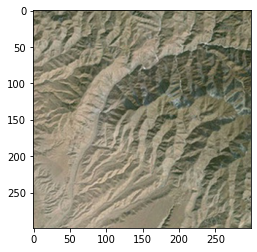

Human-annotated Caption:
 it is a piece of yellow mountain .
Generated Caption:
 it is a piece of green mountains with snow partly .
BLEU score: 0.3672056269893592
_____________________________________
../../s3/valid/rsicd_denseresidential_210.jpg


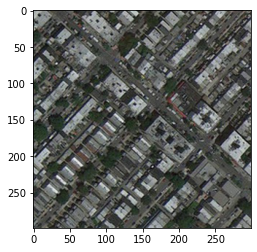

Human-annotated Caption:
 the residential of grey roof buildings is compactly laid out as a whole .
Generated Caption:
 many buildings and some green trees are in a dense residential area .
BLEU score: 1.2564066184005522e-231
_____________________________________
../../s3/valid/rsicd_school_163.jpg


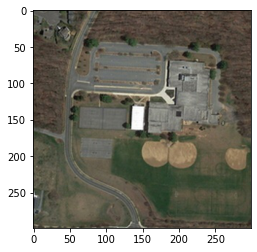

Human-annotated Caption:
 the road through the brown fields and gray building .
Generated Caption:
 a large number of trees have been built on the land .
BLEU score: 1.1640469867513693e-231
_____________________________________
../../s3/valid/ucm_997.jpg


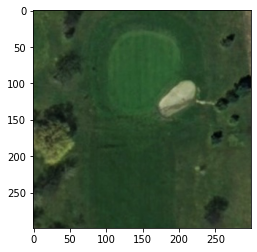

Human-annotated Caption:
 This is a part of a golf course with green turfs and trees .
Generated Caption:
 A part of a golf course with green turfs and some bunkers and withered trees .
BLEU score: 0.5554570250728591
_____________________________________
../../s3/valid/rsicd_industrial_240.jpg


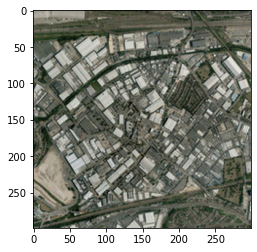

Human-annotated Caption:
 many buildings are in an industrial area .
Generated Caption:
 many buildings are in a dense rectangular area .
BLEU score: 0.3549481056010053
_____________________________________
../../s3/valid/rsicd_00613.jpg


Human-annotated Caption:
 the playground with orange and bright green is next to a a blue building.
Generated Caption:
 a playground is surrounded by many green trees and many buildings .
BLEU score: 1.2390051155620427e-231
_____________________________________
../../s3/valid/ucm_637.jpg


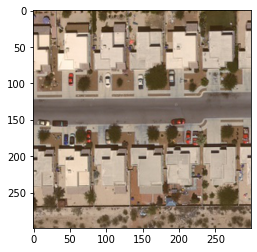

Human-annotated Caption:
 This is a dense residential area .
Generated Caption:
 Lots of houses arranged neatly and some roads go through them .
BLEU score: 9.788429383461836e-232
_____________________________________
../../s3/valid/rsicd_commercial_190.jpg


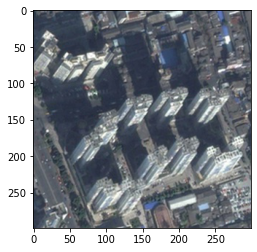

Human-annotated Caption:
 many buildings are in a commercial area .
Generated Caption:
 many buildings and some green trees are in a commercial area .
BLEU score: 0.46924700641055994
_____________________________________
../../s3/valid/rsicd_meadow_94.jpg


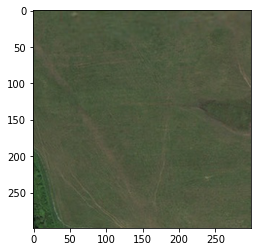

Human-annotated Caption:
 long grass speared out buds .
Generated Caption:
 several green trees are in a piece of green meadow .
BLEU score: 1.0003688322288243e-231
_____________________________________
../../s3/valid/rsicd_pond_378.jpg


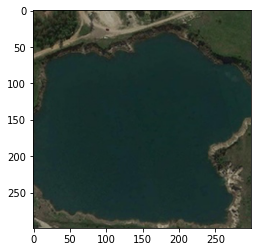

Human-annotated Caption:
 there is a huge lake on the land .
Generated Caption:
 many green trees are around an irregular pond .
BLEU score: 1.0518351895246305e-231
_____________________________________
../../s3/valid/rsicd_church_233.jpg


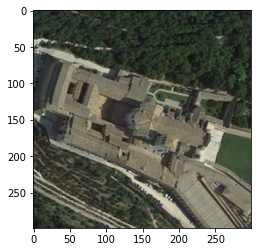

Human-annotated Caption:
 the church is surrounded by dark green trees .
Generated Caption:
 A house with plants surrounded is in the sparse residential area .
BLEU score: 1.384292958842266e-231
_____________________________________
../../s3/valid/rsicd_playground_97.jpg


Human-annotated Caption:
 there's a green field on the playground .
Generated Caption:
 a football field is in a stadium .
BLEU score: 1.4256605770826504e-231
_____________________________________
../../s3/valid/ucm_1254.jpg


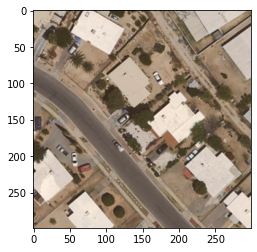

Human-annotated Caption:
 It is a medium residential area with houses arranged neatly .
Generated Caption:
 some buildings and many green trees are in a medium residential area .
BLEU score: 0.2044800736021839
_____________________________________
../../s3/valid/rsicd_bareland_67.jpg


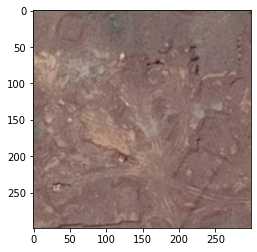

Human-annotated Caption:
 this large bare land area is very broad .
Generated Caption:
 it is a piece of irregular khaki and green bare land.
BLEU score: 1.1896457329133973e-231
_____________________________________
../../s3/valid/rsicd_farmland_195.jpg


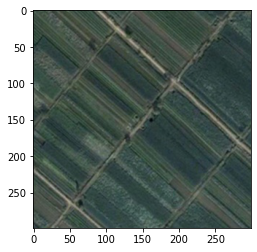

Human-annotated Caption:
 many pieces of farmlands are together .
Generated Caption:
 many pieces of farmlands are together .
BLEU score: 1.0
_____________________________________
../../s3/valid/rsicd_meadow_218.jpg


Human-annotated Caption:
 several sparse green trees are in a piece of green meadows .
Generated Caption:
 it is a piece of bare land.
BLEU score: 2.4581521049290787e-78
_____________________________________
../../s3/valid/rsicd_00275.jpg


Human-annotated Caption:
 it is obvious that there is a flow of turns where there is a bridge connecting the river on both sides .
Generated Caption:
 many buildings are around a playground near a road .
BLEU score: 4.061021221358935e-232
_____________________________________
../../s3/valid/rsicd_denseresidential_16.jpg


Human-annotated Caption:
 many buildings and many green trees are in a dense residential area .
Generated Caption:
 many buildings with some green trees are in a dense residential area .
BLEU score: 0.7016035864257111
_____________________________________
../../s3/valid/rsicd_resort_4.jpg


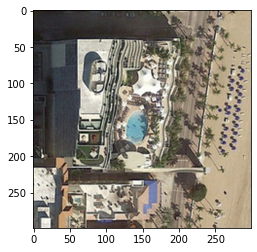

Human-annotated Caption:
 a lot of coconut trees were planted on the side of the beach .
Generated Caption:
 a large building with a parking lot is near a piece of buildings .
BLEU score: 1.331960397810445e-231
_____________________________________
../../s3/valid/ucm_1124.jpg


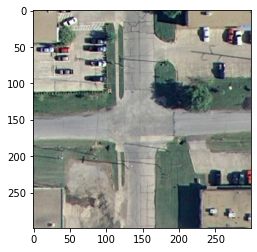

Human-annotated Caption:
 An intersection with no cars or pedestrians .
Generated Caption:
 Many mobile homes are arranged haphazardly with some cars parked at the roadside in the mobile home park .
BLEU score: 1.1484186507842885e-231
_____________________________________
../../s3/valid/rsicd_center_156.jpg


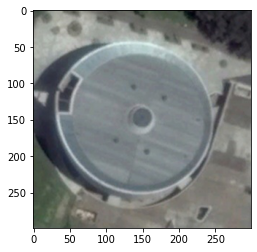

Human-annotated Caption:
 some green trees and a large building are around a circle center building .
Generated Caption:
 a playground is next to several buildings .
BLEU score: 6.085166479973199e-232
_____________________________________
../../s3/valid/rsicd_denseresidential_209.jpg


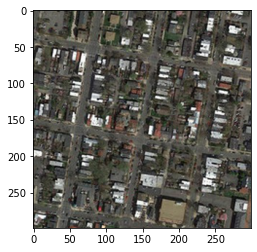

Human-annotated Caption:
 many buildings and green trees are in a dense residential area .
Generated Caption:
 many buildings and green trees are in a dense residential area .
BLEU score: 1.0
_____________________________________
../../s3/valid/ucm_1433.jpg


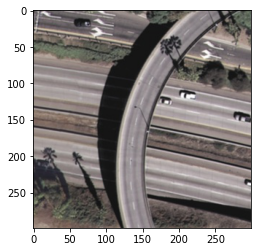

Human-annotated Caption:
 An overpass with a road go across another two roads diagonally .
Generated Caption:
 There are two different size of storage tanks on the ground .
BLEU score: 1.1640469867513693e-231
_____________________________________
../../s3/valid/rsicd_commercial_68.jpg


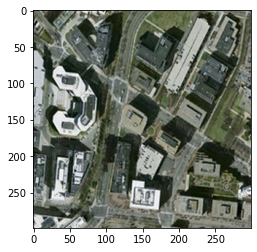

Human-annotated Caption:
 the city of skyscrapers .
Generated Caption:
 many buildings are in a commercial area .
BLEU score: 1.0832677820940877e-231
_____________________________________
../../s3/valid/rsicd_school_287.jpg


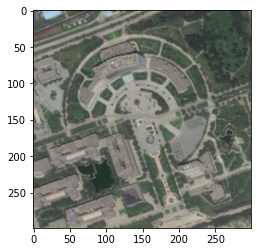

Human-annotated Caption:
 some buildings and many green trees are in a school .
Generated Caption:
 many green trees are around s square square .
BLEU score: 0.25271148634948987
_____________________________________
../../s3/valid/rsicd_commercial_151.jpg


Human-annotated Caption:
 a commercial area has many buildings and green trees .
Generated Caption:
 many buildings and some green trees are in a school .
BLEU score: 4.661032518640916e-78
_____________________________________
../../s3/valid/rsicd_forest_65.jpg


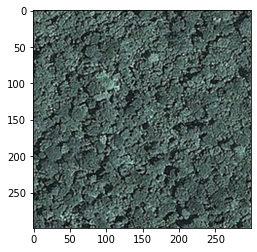

Human-annotated Caption:
 a large area of tall trees was planted on the land .
Generated Caption:
 many green trees are in a forest .
BLEU score: 8.647068503442337e-232
_____________________________________
../../s3/valid/rsicd_bareland_193.jpg


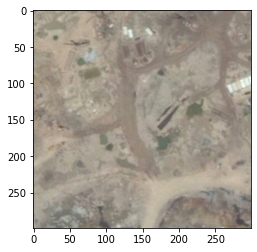

Human-annotated Caption:
 the wasteland is divided into several parts by curly pathways .
Generated Caption:
 many green trees and a piece of yellow bare land.
BLEU score: 0
_____________________________________
../../s3/valid/rsicd_00386.jpg


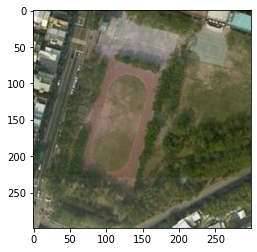

Human-annotated Caption:
 this is a straight road, with a football field on its side, surrounded by green trees .
Generated Caption:
 a playground is surrounded by many green trees and some buildings .
BLEU score: 5.6118326010004074e-155
_____________________________________
../../s3/valid/rsicd_bridge_70.jpg


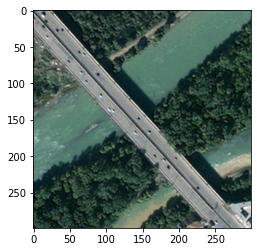

Human-annotated Caption:
 on the ground with a lush forest .
Generated Caption:
 a bridge is over a river with several green trees and buildings are in two sides of a river with a bridge over it .
BLEU score: 3.966566290876102e-155
_____________________________________
../../s3/valid/rsicd_pond_161.jpg


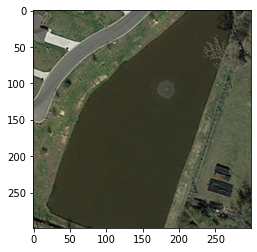

Human-annotated Caption:
 a pond is near a road and several sparse green trees .
Generated Caption:
 many green trees are around two baseball fields .
BLEU score: 4.828970785282294e-155
_____________________________________
../../s3/valid/ucm_564.jpg


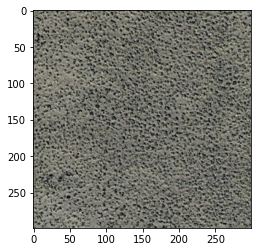

Human-annotated Caption:
 This is a chaparral .
Generated Caption:
 many green trees are in a forest .
BLEU score: 1.2882297539194154e-231
_____________________________________
../../s3/valid/rsicd_bareland_113.jpg


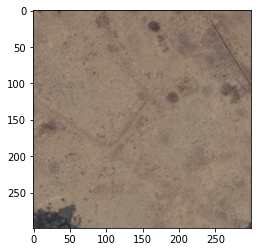

Human-annotated Caption:
 several small green trees are in a piece of bare land.
Generated Caption:
 several green trees are near a piece of bare land.
BLEU score: 0.4895914832758051
_____________________________________
../../s3/valid/rsicd_river_369.jpg


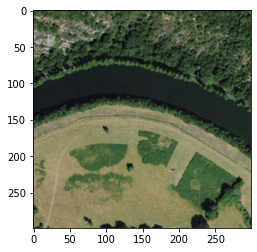

Human-annotated Caption:
 many trees are planted on both sides of the river .
Generated Caption:
 A part of a golf course with green turfs and some bunkers and withered trees .
BLEU score: 1.1988328686372911e-231
_____________________________________
../../s3/valid/rsicd_port_267.jpg


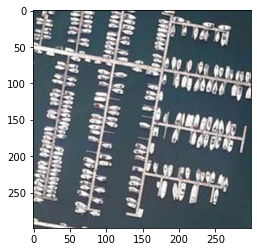

Human-annotated Caption:
 many white boats are orderly in a port .
Generated Caption:
 many boats are orderly in a port near several green trees .
BLEU score: 0.44833867003844585
_____________________________________
../../s3/valid/rsicd_railwaystation_99.jpg


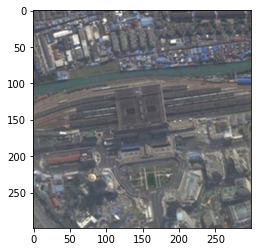

Human-annotated Caption:
 many buildings are in two sides of a railway station .
Generated Caption:
 many buildings and some green trees are in a commercial area .
BLEU score: 8.190757052088229e-155
_____________________________________
../../s3/valid/rsicd_forest_20.jpg


Human-annotated Caption:
 many green trees form a piece of forest .
Generated Caption:
 many green trees are in a piece of forest .
BLEU score: 0.5253819788848316
_____________________________________
../../s3/valid/rsicd_forest_222.jpg


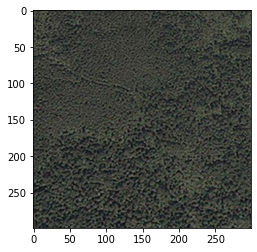

Human-annotated Caption:
 a vast expanse of forest .
Generated Caption:
 many green trees are in a piece of green meadow .
BLEU score: 1.3165594234639305e-231
_____________________________________
../../s3/valid/rsicd_bareland_221.jpg


Human-annotated Caption:
 many marks like ripples are in a piece of yellow bare land.
Generated Caption:
 a few crooked paths pass through the farm .
BLEU score: 7.536728468577135e-232
_____________________________________
../../s3/valid/rsicd_sparseresidential_157.jpg


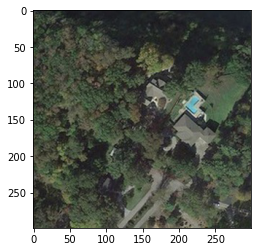

Human-annotated Caption:
 many green trees are around several buildings and a swimming pool .
Generated Caption:
 a gray building is surrounded by many green trees .
BLEU score: 3.432765109268027e-78
_____________________________________
../../s3/valid/rsicd_beach_167.jpg


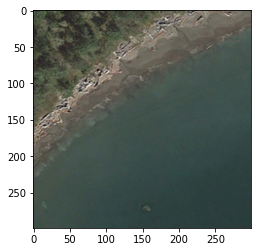

Human-annotated Caption:
 a piece of green ocean is near many green trees .
Generated Caption:
 white waves in green ocean is next to yellow beach .
BLEU score: 3.661843723291765e-78
_____________________________________
../../s3/valid/rsicd_park_42.jpg


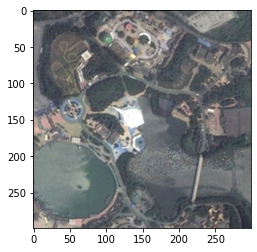

Human-annotated Caption:
 an artificial lake was built in the park .
Generated Caption:
 many green trees and several buildings are around a park with many green trees and a pond .
BLEU score: 1.0518351895246305e-231
_____________________________________
../../s3/valid/rsicd_farmland_61.jpg


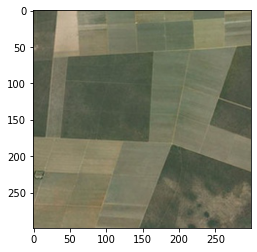

Human-annotated Caption:
 a lot of green farmland has been planted on the land .
Generated Caption:
 many pieces of farmlands are together .
BLEU score: 6.520501036082648e-232
_____________________________________
../../s3/valid/rsicd_playground_237.jpg


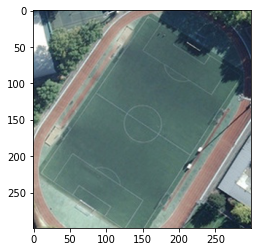

Human-annotated Caption:
 some green trees and several buildings are around a playground with a football field in it .
Generated Caption:
 some green trees are near a playground with a football field in it .
BLEU score: 0.5761979573579521
_____________________________________
../../s3/valid/ucm_1047.jpg


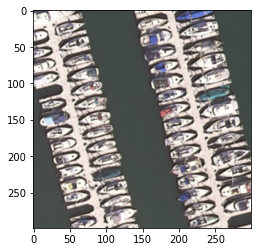

Human-annotated Caption:
 Lots of boats docked at the harbor and the water is deep blue .
Generated Caption:
 Lots of boats docked neatly at the harbor and just a few positions are free .
BLEU score: 0.31535540524901323
_____________________________________
../../s3/valid/rsicd_park_148.jpg


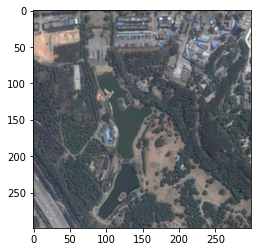

Human-annotated Caption:
 some buildings are near a park with many green trees around a pond .
Generated Caption:
 many buildings and green trees are in a resort .
BLEU score: 5.280418033662713e-155
_____________________________________
../../s3/valid/ucm_1154.jpg


Human-annotated Caption:
 An intersection with many cars on the road .
Generated Caption:
 a lot of white planes .
BLEU score: 7.060301868108111e-232
_____________________________________
../../s3/valid/ucm_69.jpg


Human-annotated Caption:
 There is a piece of farmland .
Generated Caption:
 It is a piece of farmland .
BLEU score: 0.8091067115702212
_____________________________________
../../s3/valid/rsicd_00106.jpg


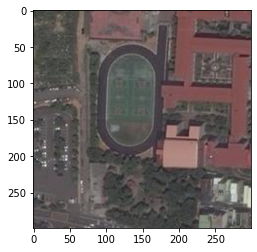

Human-annotated Caption:
 the playground consists of four basketball courts while there are some houses with red roofs aside .
Generated Caption:
 a playground is surrounded by many buildings and some green trees
BLEU score: 6.8949282624564e-232
_____________________________________


In [70]:
for z in range(20):
    pic = test_paths[z]
    img_features = test_img_features[z]
    print(pic)
    x = plt.imread(pic)
    plt.imshow(x)
    plt.show()
    print("Human-annotated Caption:\n", test_descriptions[z][0])
    generated = generateCaption(img_features)
    print("Generated Caption:\n", generated)
    print("BLEU score:", 
        bleu_score.sentence_bleu([test_descriptions[z][0].split()], generated.split()))

    print("_____________________________________")

#### Compare randomly initialized embedding matrix trained on captioins and pre-trained embedding matrix trained on captions

In [71]:
# word_pairs = [('buildings','pools'), 
#               ('ocean', 'beach'), 
#               ('trees', 'green'), 
#               ('several', 'road'), 
#               ('planted', 'mountain'),
#               ('bridge', 'river'),
#               ('pond', 'desert')
#              ]

In [72]:
# results = {'word1': [],
#            'word2': [],
#            'cosine similarity (trained on captions)': [],
#            'cosine similarity (pre-trained)': []}
# for word in word_pairs:

#     results['word1'].append(word[0])
#     results['word2'].append(word[1])

#     results['cosine similarity (trained on captions)']\
#     .append(
#         np.squeeze(
#         cosine_similarity(
#             caption_model_1.decoder.embedding.weight.cpu().data.numpy()[wordtoidx[word[0]]].reshape(1, -1),
#             caption_model_1.decoder.embedding.weight.cpu().data.numpy()[wordtoidx[word[1]]].reshape(1, -1)
#         ))) 
    
#     results['cosine similarity (pre-trained)']\
#     .append(
#         np.squeeze(
#         cosine_similarity(
#             caption_model_2.decoder.embedding.weight.cpu().data.numpy()[wordtoidx[word[0]]].reshape(1, -1),
#             caption_model_2.decoder.embedding.weight.cpu().data.numpy()[wordtoidx[word[1]]].reshape(1, -1)
#         )))
   


In [73]:
# pd.DataFrame(results)

word1     word2 cosine similarity (trained on captions)  \
0  buildings     pools                             0.124274045   
1      ocean     beach                              0.10941522   
2      trees     green                            -0.038271036   
3    several      road                             -0.12150155   
4    planted  mountain                            -0.011771376   
5     bridge     river                            -0.008912719   
6       pond    desert                            -0.107715875   

  cosine similarity (pre-trained)  
0                      0.36653233  
1                      0.32397372  
2                      0.20548396  
3                      0.07643281  
4                     0.100742735  
5                      0.52526104  
6                       0.3227794

In [40]:
# generate results
results = {}
for n in range(len(test_paths)):
    pic = test_paths[n]
    # note the filename splitting depends on path
    filename = pic.split('/')[4]
    img_features = test_img_features[n]
    generated = generateCaption(img_features)
    results[filename] = generated

In [46]:
# save the results 
save_path = f'{root_captioning}/fz_notebooks/'
with open(save_path + 'test_results_n9.3.json', 'w') as fp:
    json.dump(results, fp)